In [1]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum

In [2]:
import os

os.environ['HADOOP_HOME'] = r'/home/ubuntu/spark-2.4.7-bin-hadoop2.7/hadoop-2.7.0/'
os.environ['HADOOP_COMMON_LIB_NATIVE_DIR'] = os.environ['HADOOP_HOME'] + '/lib/native'
os.environ['HADOOP_OPTS'] = "-Djava.library.path={}/lib".format(
    os.environ['HADOOP_HOME'])

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql import SparkSession
import sparknlp
import pandas as pd
pd.set_option('display.max_columns', 100, 'display.max_colwidth', 1000, 'display.max_rows', 1000,
              'display.float_format', lambda x: '%.2f' % x)

spark = SparkSession.builder \
    .master("local[*]")\
    .config("spark.driver.memory", "4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.6.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()

Load in data

In [5]:
# File location and type
file_location = "/home/ubuntu/notebooks/sample_amazon_review_5_train.json"
file_type = "json"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
reviews = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(reviews)

DataFrame[asin: string, image: array<string>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, style: struct<Capacity::string,Color Name::string,Color::string,Colorj::string,Colour::string,Configuration::string,Connectivity::string,Connector Type::string,Content::string,Cutting Diameter::string,Department::string,Design::string,Diameter::string,Digital Storage Capacity::string,Display Height::string,Edition::string,Flavor Name::string,Flavor::string,Flex::string,Format::string,Gauge::string,Gem Type::string,Gift Amount::string,Grip Type::string,Hand Orientation::string,Head Diameter::string,Inside Diameter::string,Item Display Length::string,Item Display Weight::string,Item Package Quantity::string,Item Shape::string,Length::string,Line Weight::string,Loft::string,Material Type::string,Material::string,Metal Stamp::string,Metal Type::string,Model Name::string,Model Number::string,Model::string,Nominal Outside Diameter::string,Number of 

In [6]:
# Create a view or table

temp_table_name = "reviews"
reviews.createOrReplaceTempView(temp_table_name)

In [7]:
spark.sql('select reviewText, overall from reviews').toPandas()

,reviewText,overall
0,"This is a great start, and a very cool example of the potential of Echo in a connected home. It's not perfect, though, and I don't get the sense that the Garageio manufacturer is incrementally enhancing this skill - I fear that's it's as good as its going to get.\n\nIssue #1\n\nEach garage door is given a name. I have one with my name and one with my wife's name. Our names are both single syllable, but start with different letters and have completely different phenomes.\n\nMe: Alexa, ask garageio to close Dean's door.\nEcho: Closing Mary's door.\nMe: What the heck?!?\n\nIt happens all the time, even when standing right next to the Echo. Sure, I could rename the doors to something that the Echo can distinguish between, but it shouldn't be necessary. I recognize that this is likely an Amazon thing and not a Garageio thing, but the fact that Echo sits in my house and can't distinguish between the spoken names of two residents in the home is kinda sad.\n\nIssue #2\n\nWe have thre...",2.00
1,I've played the game a handful of times and its rare it actually gets my animal right. It takes the same general concept of 21 questions but the pay off is never there.,1.00
2,I have been using automatic for more than a year and Alexa took it to another next level . This skill can even do more based our historic driving data and also using the driving score.,4.00
3,Exactly what I needed for my mother!,5.00
4,"It does not tell you when the reruns are on., only the next show you in the series. Not bad but not usefull if you want to watch sonething like love it or list it or sone other show that does mot need to be the newest show. It woukd also be nice to be able to set your cable company and fet actual channels, yo be hobest if I have to look up what network is on what channel I may as well look up the time too. Other then those things it does work as stated",3.00
...,...,...
359988,"Editing has been done and corrections made so the 5 stars are now well and truly worth it. Once again Halloween LaVue has gotten into more trouble than you can shake a stick at, or in this case a wedding dress at. This time though Halloweens mum and BFF are also affected. That doesn't go down well at all.",5.00
359989,Thank you,5.00
359990,Beautiful shirt!! It is super cute and fits so nicely. It hangs beautifully on me. Absolutely love it. It isn't to thick and it's not too thin either it is just right and the garments stitching is good. It is a high quality shirt. Absolutely love the material. It is super soft.,5.00
359991,"Top was too big, bottoms too small, cheaply made",1.00


In [8]:
reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Capacity:: string (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Colorj:: string (nullable = true)
 |    |-- Colour:: string (nullable = true)
 |    |-- Configuration:: string (nullable = true)
 |    |-- Connectivity:: string (nullable = true)
 |    |-- Connector Type:: string (nullable = true)
 |    |-- Content:: string (nullable = true)
 |    |-- Cutting Diameter:: string (nullable = true)
 |    |-- Department:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Diameter:: string (nullable = true)
 |    |-- Digi

Filter out null reviews

In [9]:
reviews = reviews.filter(reviews.reviewText.isNotNull())

In [10]:
reviews.createOrReplaceTempView('reviews')

How many reviews are there?

In [11]:
spark.sql('SELECT COUNT(*) FROM reviews').toPandas()

,count(1)
0,359835


Inspect a couple reviews

In [12]:
spark.sql('SELECT * FROM reviews LIMIT 2').toPandas()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,B017OBI3AQ,None,2.00,"This is a great start, and a very cool example of the potential of Echo in a connected home. It's not perfect, though, and I don't get the sense that the Garageio manufacturer is incrementally enhancing this skill - I fear that's it's as good as its going to get.\n\nIssue #1\n\nEach garage door is given a name. I have one with my name and one with my wife's name. Our names are both single syllable, but start with different letters and have completely different phenomes.\n\nMe: Alexa, ask garageio to close Dean's door.\nEcho: Closing Mary's door.\nMe: What the heck?!?\n\nIt happens all the time, even when standing right next to the Echo. Sure, I could rename the doors to something that the Echo can distinguish between, but it shouldn't be necessary. I recognize that this is likely an Amazon thing and not a Garageio thing, but the fact that Echo sits in my house and can't distinguish between the spoken names of two residents in the home is kinda sad.\n\nIssue #2\n\nWe have thre...","12 17, 2015",A1SWNXP37TK50J,DBanks,None,"I want to love this so much, but it needs work",1450310400,False,18
1,B017OBYNZU,None,1.00,I've played the game a handful of times and its rare it actually gets my animal right. It takes the same general concept of 21 questions but the pay off is never there.,"12 9, 2015",A2A0K9J8XFJ9J4,Phoenix Heat,None,"Cool concept, bad execution",1449619200,False,None


Which users have posted the most reviews?

In [13]:
query = '''
SELECT reviewerName, reviewerID, COUNT(*) as num_reviews
FROM reviews
GROUP BY reviewerID, reviewerName
ORDER BY num_reviews DESC
'''
spark.sql(query).show(truncate=50)

+----------------------------------------------+--------------+-----------+
|                                  reviewerName|    reviewerID|num_reviews|
+----------------------------------------------+--------------+-----------+
|                                    Grady Harp|A328S9RN3U5M68|         28|
|                                 Neal Reynolds| AHUT55E980RDR|         19|
|                                  Bookreporter|A2F6N60Z96CAJI|         19|
|                                Steven H Propp|A2OJW07GQRNJUT|         17|
|                                 E. A. Solinas|A1D2C0WDCSHUWZ|         16|
|Heather- A Crazy Vermonter&#039;s Book Reviews|A1JLU5H1CCENWX|         15|
|                                  LAS Reviewer|A13QTZ8CIMHHG4|         13|
|                                 Israel Drazin|A2KWQ64TRHB3YH|         12|
|                                 Robert Morris|A26JGAM6GZMM4V|         12|
|                                      Sandy S.| AW4NFCPN81CS3|         12|
|           

Number of reviews over time

Obviously as Amazon became more popular, the number of reviews grew

In [14]:
query = '''
SELECT COUNT(*) as num_reviews_per_year, YEAR(FROM_UNIXTIME(unixReviewTime)) AS year 
FROM reviews 
GROUP BY year 
ORDER BY year DESC
'''

spark.sql(query).toPandas()

,num_reviews_per_year,year
0,26850,2018
1,62088,2017
2,81379,2016
3,71979,2015
4,50799,2014
5,30646,2013
6,11579,2012
7,6067,2011
8,4069,2010
9,3418,2009


array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

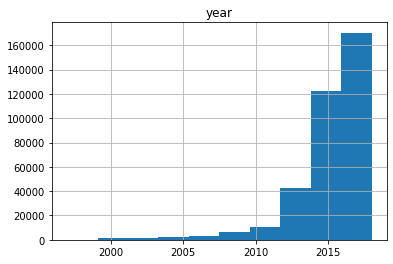

In [15]:
spark.sql('SELECT YEAR(FROM_UNIXTIME(unixReviewTime)) AS year FROM reviews').toPandas().hist()

It seems most reviews are actually 5 stars!

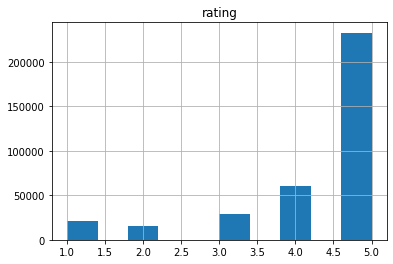

In [16]:
%matplotlib inline
spark.sql('SELECT overall AS rating FROM reviews').toPandas().hist();

### Show products with the most reviews

TODO: Need to pull out all products that appear in the reviews from product metadata.

In [17]:
query = '''
SELECT asin, COUNT(*) as num_reviews
FROM reviews
GROUP BY asin
ORDER BY num_reviews DESC
'''
spark.sql(query).show(truncate=50)

+----------+-----------+
|      asin|num_reviews|
+----------+-----------+
|038568231X|         77|
|0007420412|         68|
|B000X1MX7E|         65|
|0297859382|         62|
|B000YXC2LI|         50|
|0312577222|         50|
|0099911701|         49|
|0007548672|         49|
|B00FLYWNYQ|         47|
|000711835X|         47|
|B000K5THYU|         47|
|0553418025|         45|
|B000W5QSYA|         44|
|1683247353|         44|
|B006GWO5WK|         44|
|B000OX89XI|         41|
|B00YSG2ZPA|         41|
|B00028AVDG|         40|
|B003156C4E|         39|
|1503943372|         39|
+----------+-----------+
only showing top 20 rows



## Bag of Words
- We will use NLTK's list of stopwords to conduct stopword removal, and visualise results in wordclouds
- We will also remove punctuation and capitalization

In [18]:
import re
sw = stopwords.words("english")
def remove_stopwords(x):    
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

def lower(text):
  return text.lower()
  
def removePunctuation(text):
  return re.sub('[^A-Za-z0-9 ]+', '', text)  
  
# UDF = user defined function
nosw = udf(remove_stopwords)
rp = udf(removePunctuation)
lc = udf(lower)
# Register UDF with Spark
spark.udf.register("nosw", nosw)
spark.udf.register("rp", rp)
spark.udf.register("lc", lc)

# Creates a new column in reviews which contains the review with no stop words
reviews = reviews.withColumn('text_nosw', lc(rp(nosw('reviewText'))))

In [19]:
display(reviews)

DataFrame[asin: string, image: array<string>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, style: struct<Capacity::string,Color Name::string,Color::string,Colorj::string,Colour::string,Configuration::string,Connectivity::string,Connector Type::string,Content::string,Cutting Diameter::string,Department::string,Design::string,Diameter::string,Digital Storage Capacity::string,Display Height::string,Edition::string,Flavor Name::string,Flavor::string,Flex::string,Format::string,Gauge::string,Gem Type::string,Gift Amount::string,Grip Type::string,Hand Orientation::string,Head Diameter::string,Inside Diameter::string,Item Display Length::string,Item Display Weight::string,Item Package Quantity::string,Item Shape::string,Length::string,Line Weight::string,Loft::string,Material Type::string,Material::string,Metal Stamp::string,Metal Type::string,Model Name::string,Model Number::string,Model::string,Nominal Outside Diameter::string,Number of 

In [20]:
reviews.select('text_nosw').toPandas().head()

,text_nosw
0,great start cool example potential echo connected home perfect though get sense garageio manufacturer incrementally enhancing skill fear thats good going getissue 1each garage door given name one name one wifes name names single syllable start different letters completely different phenomesme alexa ask garageio close deans doorecho closing marys doorme heckit happens time even standing right next echo sure could rename doors something echo distinguish between necessary recognize likely amazon thing garageio thing fact echo sits house cant distinguish spoken names two residents home kinda sadissue 2we three garage doors 3 door garageio black box workalexa ask garageio doors openalexa ask garageio close doorswhats sadly necessaryalexa ask garageio deans door openalexa ask garageio marys door openalexa ask garageio close marys dooryou cant ask garageio doors open ask close doors ask status door turn much faster open garageio app scroll door status pages walk outside look gar...
1,ive played game handful times rare actually gets animal right takes general concept 21 questions pay never there
2,using automatic year alexa took another next level skill even based historic driving data also using driving score
3,exactly needed mother
4,tell reruns on next show series bad usefull want watch sonething like love list sone show mot need newest show woukd also nice able set cable company fet actual channels yo hobest look network channel may well look time too things work stated


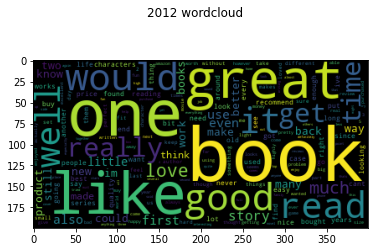

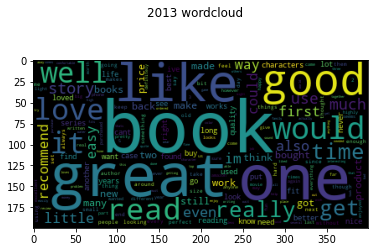

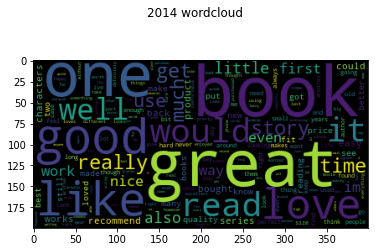

In [21]:
def flat_list(column):
    corpus = []
    for row in column:
        for w in row.split(' '):
            corpus.append(w)
    return corpus

def corpus_creator(text_col):
    corpus = text_col.rdd \
                    .flatMap(flat_list) \
                    .map(lambda x: (x, 1)) \
                    .reduceByKey(lambda x, y: x+y ) \
                    .sortBy(lambda x: x[1], ascending=False) \
                    .toDF() \
                    .withColumnRenamed('_1','reviewText') \
                    .withColumnRenamed('_2','count')
    return corpus

def annual_reviews(year):
    annual_reviews = reviews.select('text_nosw') \
                        .filter('YEAR(FROM_UNIXTIME(unixReviewTime))=={}'.format(year)) \
                        .withColumnRenamed('text_nosw','reviewText')
    return annual_reviews

def wordcloud(corpus_sdf, text_name='reviewText'):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row[text_name]] = row['count']
        
    wordcloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(wordcloud);


years_list = list(range(2012, 2015))

annual_corpora = {}
for year in years_list:
    annual_corpora[str(year)] = corpus_creator(annual_reviews(year))

for key,value in annual_corpora.items():
    fig, ax = plt.subplots()
    ax = wordcloud(value)
    fig.suptitle('{} wordcloud'.format(key))